In [1]:
# External imports
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from pathlib import Path


# Internal imports
from pareto.data_io import get_cache, get_session, get_unit_channels, get_spike_times, get_stimulus_presentations, get_units_by_area, get_trials
from pareto.preprocessing import make_psth_cube, get_image_trials, arrange_image_onsets_to_trial, group_stims_by_frame_index
from pareto.stats import visual_selectivity_filter, subtract_baseline, zscore, roc_analysis, get_snr, population_sparseness, auc_roc

/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Obtaining cache

cache = get_cache()

# Obtaining metadata

ecephys_sessions_table = cache.get_ecephys_session_table()

In [3]:
# Obtaining the IDs for 4 random familiar sessions

# rd.seed(11)

# sis = ecephys_sessions_table[ecephys_sessions_table['experience_level'] == 'Familiar'].index.values.tolist()
# r_keys = rd.sample(range(0, len(sis)), 4)
# selected_sessions = [sis[i] for i in r_keys]

session_ids = [1044385384, 1104052767, 1112302803, 1139846596, 1104058216]

In [4]:
# Restructuring analysis to fit a single session, then reapplying analysis across all sessions

session = get_session(session_ids[2])

# Obtaining subdata from familiar session

units = get_unit_channels(session)
trials = get_trials(session)
stimulus_presentations = get_stimulus_presentations(session)
spike_times = get_spike_times(session)

# Obtaining units by visual areas

areas_of_interest = ['VISp', 'VISpm']
area_units = get_units_by_area(units, areas_of_interest)

for area in areas_of_interest:
  print(f"The number of units in {area} are: {area_units['structure_acronym'].value_counts()[area]}")

/opt/anaconda3/envs/allensdk/lib/python3.11/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.6.0-alpha, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


The number of units in VISp are: 155
The number of units in VISpm are: 138


In [5]:
# Filtering units by quality metrics

quality_unit_filter = ((area_units['snr'] >= 1) & (area_units['isi_violations'] < 1) & (area_units['firing_rate'] > 0.1))
filtered_area_units = area_units.loc[quality_unit_filter].copy()

for area in areas_of_interest:
  print(f"The number of filtered units in {area} are: {filtered_area_units['structure_acronym'].value_counts()[area]}")

The number of filtered units in VISp are: 121
The number of filtered units in VISpm are: 95


In [6]:
# Obtaining a dictionary of onsets, start frames, active and is_change per each image condition

image_dat = {
    img: {
        "onsets": grp["start_time"].values,
        "start_frame": grp["start_frame"].values,
        "active": grp["active"].values,
        "is_change": grp["is_change"].values,
    }
    for img, grp in stimulus_presentations.groupby("image_name")
}

del image_dat['omitted']

for img, dat in image_dat.items():

  print(len(dat['onsets'][dat['active']]))

566
496
593
746
619
514
633
470


In [7]:
# Obtaining Wilcoxon signed-rank test results for visual selectivity

wilcoxon_selectivity = Path.cwd().parents[1] / 'data' / 'processed' / f'{session_ids[2]}.csv'
per_image_stats_table = pd.read_csv(wilcoxon_selectivity)

# Translating to unit filter mask

selectivity_filters = {}

for image, _ in image_dat.items():

  stats = per_image_stats_table.loc[per_image_stats_table['image'] == image]
  mask = (stats['reject'] & stats['pass_effect']).values
  selectivity_filters[image] = mask

In [8]:
# Collecting spike times, raw PSTH traces and baseline subtracted PSTH traces for each image condition

windows = {
  "pre": (-0.25, 0),
  "evoked": (0, 0.25),
  "post": (0.25, 0.5)
}

def spike_dat(
    units, 
    spikes, 
    image_dat, 
    windows, 
    bin_size
  ):

  img_sd = {}

  for img, dat in image_dat.items():

    onsets = dat['onsets']
    img_units = units[selectivity_filters[img]]

    for area in areas_of_interest:

      area_units = img_units.loc[units['structure_acronym'] == area]
      raw_psths, unit_ids, bins, sts = make_psth_cube(area_units, spikes, onsets, windows, bin_size)
      bsub_psths = subtract_baseline(raw_psths, windows["pre"], bins)

      area_dat = {
        "raw_psth": raw_psths,
        "bsub_psth": bsub_psths,
        "spike_times": sts,
        "unit_ids": unit_ids
      }

      if img not in img_sd:
        img_sd[img] = {}

      img_sd[img][area] = area_dat

  return img_sd, bins

img_sd, bins = spike_dat(filtered_area_units, spike_times, image_dat, windows, bin_size=0.01)

In [9]:
# Programming the sampling pipeline

from scipy import stats

sample_window = 5

def sample_stats(
    img_sd,
    sample_window
):
  
  out = {}

  for img, area_sd in img_sd.items():
    for area, sd in area_sd.items():
      for i in range(2):

        mask = image_dat[img]["active"]

        if i == 0:
          m = "active"
        else:
          m = "passive"
          mask = ~mask

        raw_psths = sd['raw_psth'][:,mask,:]
        n_timebins = raw_psths.shape[2]
        n_samples = n_timebins - sample_window + 1

        windowed = np.array([
            raw_psths[:, :, i:i+sample_window].sum(axis=2) 
            for i in range(n_samples)
        ])

        w_means = windowed.mean(axis=2)
        w_vars = windowed.var(axis=2, ddof=1)

        for t in range(n_samples):

          if t not in out:
            out[t] = {}

          if area not in out[t]:
            out[t][area] = {}

          if m not in out[t][area]:
            out[t][area][m] = {"means": [], "vars": []}

          out[t][area][m]["means"].extend(w_means[t,:])
          out[t][area][m]["vars"].extend(w_vars[t,:])

  return out, n_samples


samples, n_samples = sample_stats(img_sd, sample_window)

print(samples)

{0: {'VISp': {'active': {'means': [0.0, 0.0, 0.09010600706713781, 0.054770318021201414, 0.015901060070671377, 0.0035335689045936395, 0.07420494699646643, 0.014134275618374558, 0.0017667844522968198, 0.01060070671378092, 0.0017667844522968198, 0.007067137809187279, 0.14840989399293286, 0.00530035335689046, 0.00530035335689046, 0.09010600706713781, 0.01060070671378092, 0.19964664310954064, 0.4752650176678445, 0.01060070671378092, 0.13250883392226148, 0.0636042402826855, 0.09187279151943463, 0.254416961130742, 0.0353356890459364, 0.2968197879858657, 0.0989399293286219, 0.0812720848056537, 0.04770318021201413, 0.14840989399293286, 0.01060070671378092, 0.015901060070671377, 0.10070671378091872, 0.04063604240282685, 0.07597173144876325, 0.08480565371024736, 0.0353356890459364, 0.01060070671378092, 0.10070671378091872, 0.12897526501766785, 0.0088339222614841, 0.00530035335689046, 0.24911660777385158, 0.2968197879858657, 0.32685512367491165, 0.0035335689045936395, 0.2508833922261484, 0.6978798

In [10]:
rows = []

for tp, area_dict in samples.items():

  tpb = (bins[tp] + bins[tp + sample_window - 1]) / 2

  for area, conds in area_dict.items():

    unit_ids = []

    for img, area_sd in img_sd.items():
      unit_ids.extend(area_sd[area]["unit_ids"])

    for c, st in conds.items():

      means = st["means"]
      vars_ = st["vars"]

      for uid, m, v in zip(unit_ids, means, vars_):
        rows.append({
          "time_point": tpb,
          "area": area,
          "ap": c,
          "uid": uid,
          "mean": float(m),
          "var": float(v)
        })

df = pd.DataFrame(rows)


In [11]:
print(df)

save_path = Path.cwd().parents[1] / 'data' / 'ts_fano_reg' / f'{session_ids[2]}.csv'

df.to_csv(save_path, index=False)

        time_point   area       ap         uid      mean       var
0            -0.23   VISp   active  1143987613  0.000000  0.000000
1            -0.23   VISp   active  1143987594  0.000000  0.000000
2            -0.23   VISp   active  1143987591  0.090106  0.128150
3            -0.23   VISp   active  1143987619  0.054770  0.051862
4            -0.23   VISp   active  1143987578  0.015901  0.015676
...            ...    ...      ...         ...       ...       ...
111891        0.47  VISpm  passive  1143986319  0.063830  0.068412
111892        0.47  VISpm  passive  1143986311  0.021277  0.025133
111893        0.47  VISpm  passive  1143986314  0.006383  0.006356
111894        0.47  VISpm  passive  1143986302  0.242553  0.393068
111895        0.47  VISpm  passive  1143986290  0.025532  0.024933

[111896 rows x 6 columns]


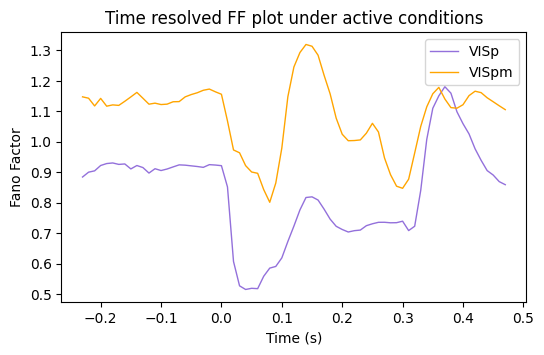

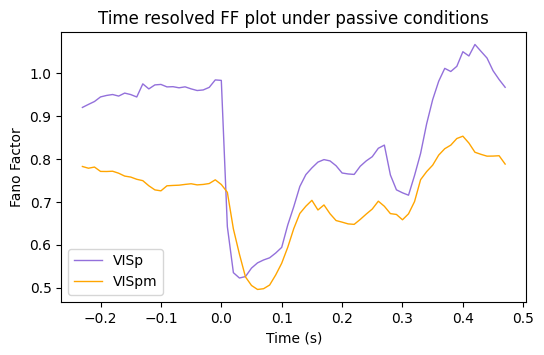

In [12]:
sections = ["active", "passive"]

def sample_fano_reg(samples):

  out = {}

  for s in sections:
    for tp, time_point in samples.items():
      for a, area in time_point.items():

        means = area[s]["means"]
        vars_ = area[s]["vars"]

        slope, intercept, r, p, std_err = stats.linregress(means, vars_)

        if tp not in out:
          out[tp] = {}

        if a not in out[tp]:
          out[tp][a] = {}

        if s not in out[tp][a]:
          out[tp][a][s] = slope

  return out

fano = sample_fano_reg(samples)
tps = [(bins[i] + bins[i + sample_window - 1]) / 2 for i in range(n_samples)]

for s in sections:

  fig, ax = plt.subplots(figsize=(6,3.5))

  for area in areas_of_interest:

    if area == "VISp":
      colour = 'mediumpurple'
    else:
      colour = 'orange'

    vals = [fano[tp][area][s] for tp in range(n_samples)]

    ax.plot(tps, vals, color=colour, lw=1, label=area)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Fano Factor")
    ax.set_title(f"Time resolved FF plot under {s} conditions")
    ax.legend()

In [13]:
# Programming the chunk sampling pipeline

chunk_size = 20

def sample_chunking_stats(
    img_sd,
    sample_window,
    chunk_size,
):

    out = {}

    for img, area_dat in img_sd.items():
        for area, dat in area_dat.items():
            for i in range(2):

                mask = image_dat[img]["active"]

                if i == 0:
                    m = "active"
                else:
                    m = "passive"
                    mask = ~mask

                raw_psths = dat["raw_psth"][:,mask,:]
                n_timebins = raw_psths.shape[2]
                n_samples = n_timebins - sample_window + 1

                windowed = np.array([
                    raw_psths[:, :, i:i+sample_window] 
                    for i in range(n_samples)
                ])

                n_chunks = int(round(raw_psths.shape[1] / chunk_size))

                sample_chunks = [
                    windowed[:, :, c*chunk_size:(c+1)*chunk_size, :].sum(axis=3)
                    for c in range(n_chunks)
                ]  

                chunk_means = [chunk.mean(axis=2) for chunk in sample_chunks]              
                chunk_vars  = [chunk.var(axis=2, ddof=1) for chunk in sample_chunks]

                for c in range(n_chunks):
                    if c not in out:
                        out[c] = {}
                    for t in range(n_samples):
                        if t not in out[c]:
                            out[c][t] = {}
                        if area not in out[c][t]:
                            out[c][t][area] = {}
                        if m not in out[c][t][area]:
                            out[c][t][area][m] = {"means": [], "vars": []}

                        out[c][t][area][m]["means"].extend(chunk_means[c][t])
                        out[c][t][area][m]["vars"].extend(chunk_vars[c][t])

    return out, n_samples

samples, n_samples = sample_chunking_stats(img_sd, sample_window, chunk_size)
tps = [(bins[i] + bins[i + sample_window - 1]) / 2 for i in range(n_samples)]

In [14]:
# Obtaining fano factor via regression analysis

sections = ["active", "passive"]

def fano_reg(sample_chunks):

  out = {}

  for s in sections:
    for c, chunk in sample_chunks.items():
      for tp, time_point in chunk.items():
        for a, area in time_point.items():

          means = area[s]["means"]
          vars_ = area[s]["vars"]

          slope, intercept, r, p, std_err = stats.linregress(means, vars_)

          if c not in out:
            out[c] = {}

          if tp not in out[c]:
            out[c][tp] = {}

          if a not in out[c][tp]:
            out[c][tp][a] = {}

          if s not in out[c][tp][a]:
            out[c][tp][a][s] = slope

  return out

chunk_fanos = fano_reg(samples)

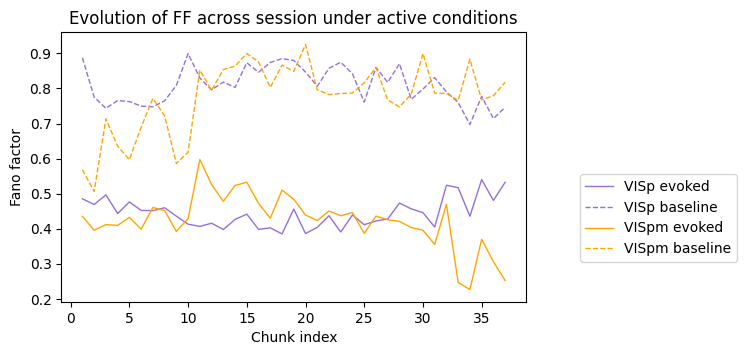

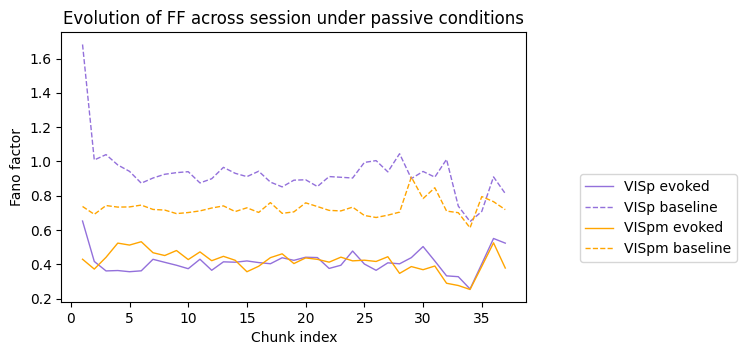

In [15]:
# Plotting fano across time

chunk_stats = {}

for c in range(len(chunk_fanos.keys())):

  chunk = chunk_fanos[c]
  area_stats = {}

  for area in areas_of_interest:

    section_stats = {}

    for s in sections:

      vals = [chunk[i][area][s] for i in chunk.keys()]
      base = np.mean(vals[0:21])
      evk = np.min(vals[21:46])
      evk_li = np.argmin(vals[21:46])
      latency = (evk_li)*0.01

      section_stats[s] = {
        "evoked_trough": evk,
        "base_mean": base,
        "latency": latency
      }
    
    area_stats[area] = section_stats

  chunk_stats[c] = area_stats


for s in sections:

  fig, ax = plt.subplots(figsize=(6,3.5))

  for area in areas_of_interest:

    if area == "VISp":
      colour = 'mediumpurple'
    else:
      colour = 'orange'
 
    evk_across = [chunk_stats[c][area][s]["evoked_trough"] for c in chunk_stats.keys()]
    base_across = [chunk_stats[c][area][s]["base_mean"] for c in chunk_stats.keys()]
    evk_across = np.array(evk_across)
    base_across = np.array(base_across)


    n_chunks = len(chunk_stats.keys())
    x = np.arange(1, n_chunks+1, 1)

    ax.plot(x, evk_across, c=colour, lw=1, label=f"{area} evoked")
    ax.plot(x, base_across, c=colour, lw=1, linestyle='dashed', label=f"{area} baseline")

    ax.set_title(f"Evolution of FF across session under {s} conditions")
    ax.set_ylabel('Fano factor')
    ax.set_xlabel('Chunk index')
    ax.legend(
      loc='upper left', 
      bbox_to_anchor=(1.10, 0.5),
      borderaxespad=0.5
    )
